# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [1]:
import numpy as np
import pandas as pd
import math as mt
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.stats import norm

cd = pd.read_csv('covid_19_clean_complete.csv')



* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.

In [2]:
#Convirtiendo dia a numero
cd['Date']= pd.to_datetime(cd['Date'])
cd.info()
cd.sort_values(by='Date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  8800 non-null   object        
 1   Country/Region  29040 non-null  object        
 2   Lat             29040 non-null  float64       
 3   Long            29040 non-null  float64       
 4   Date            29040 non-null  datetime64[ns]
 5   Confirmed       29040 non-null  int64         
 6   Deaths          29040 non-null  int64         
 7   Recovered       29040 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.8+ MB


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0
167,Curacao,Netherlands,12.169600,-68.990000,2020-01-22,0,0,0
168,Sint Maarten,Netherlands,18.042500,-63.054800,2020-01-22,0,0,0
169,NaN,Netherlands,52.132600,5.291300,2020-01-22,0,0,0
170,NaN,New Zealand,-40.900600,174.886000,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
28869,Greenland,Denmark,71.706900,-42.604300,2020-05-10,11,0,11
28870,NaN,Denmark,56.263900,9.501800,2020-05-10,10429,529,8217
28871,NaN,Djibouti,11.825100,42.590300,2020-05-10,1210,3,847
28857,Zhejiang,China,29.183200,120.093400,2020-05-10,1268,1,1267


In [3]:

dia= []
dia.append(0) 
contador_dias = 0

#El siguiente for se utiliza para agregar la columna dia al modelo.
for col in range(len(cd)):
    if col > 0:
        if cd.Date[col] == cd.Date[col-1]:
            dia.append(contador_dias)
        else:
            contador_dias+=1
            dia.append(contador_dias)
        col_ant = col-1     
cd['Dia']= dia



### Aplicar regresión lineal sobre la variable "Confirmed" transformada.

<AxesSubplot:xlabel='Dia', ylabel='Confirmed'>

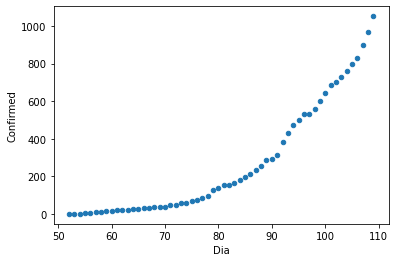

In [4]:
GT_confirmed = cd[(cd["Country/Region"] == 'Guatemala') & (cd["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Dia",y="Confirmed")

<AxesSubplot:xlabel='Dia', ylabel='ln_confirmed'>

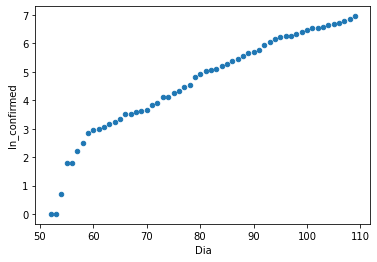

In [5]:
GT_confirmed["ln_confirmed"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Dia",y="ln_confirmed")

In [6]:
GT_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Dia,ln_confirmed
13851,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1,0,0,52,0.000000
14115,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1,0,0,53,0.000000
14379,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2,1,0,54,0.693147
14643,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6,1,0,55,1.791759
14907,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6,1,0,56,1.791759


<AxesSubplot:xlabel='Dia', ylabel='ln_confirmed'>

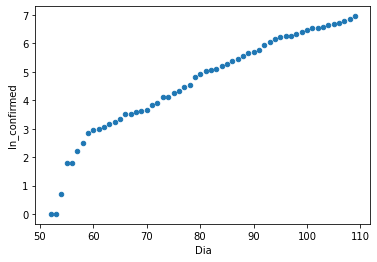

In [7]:
GT_confirmed_post24 = GT_confirmed[GT_confirmed.Dia >= 50]
GT_confirmed_post24.plot.scatter(x = "Dia",y="ln_confirmed")

## Vamos a filtrar desde el dia 8(58 contando desde inicio de anio.) CON EL OBJETIVO DE REALIZAR UN MODELO LINEAL SOBRE LOS DATOS RESTANTES

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Dia,ln_confirmed
15435,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12,1,0,58,2.484907
15699,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17,1,0,59,2.833213


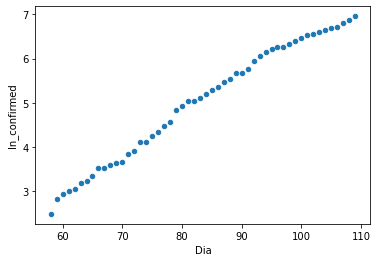

In [8]:
GT_confirmed_post24 = GT_confirmed[GT_confirmed.Dia >= 58]
GT_confirmed_post24.plot.scatter(x = "Dia",y="ln_confirmed")
GT_confirmed_post24.head(2)

In [9]:
#Eliminar
#GT_confirmed_post24['h_0_x'] = GT_confirmed_post24['ln_confirmed']*(GT_confirmed_post24['Dia'])

X = GT_confirmed_post24['Dia']
Y = GT_confirmed_post24['ln_confirmed']
m = 0
c = 0
L= 0.0001 # learning rate
epochs = 500
n= len(GT_confirmed_post24)


for i in range(epochs): 
    Y_pred = m*X + c  # The current predicted value of Y
    D_m = (-2/n) * sum(X * (Y - Y_pred))  # Derivative wrt m
    D_c = (-2/n) * sum(Y - Y_pred)  # Derivative wrt c
    m = m - L * D_m  # Update m
    c = c - L * D_c  # Update c
    
print (m, c)

0.061029609450455706 -0.006406484516792052


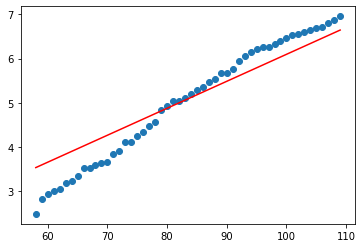

In [10]:
Y_pred = m*X + c

plt.scatter(X, Y) 
plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='red')  # regression line
plt.show()


#GT_confirmed_post24['h_0_x_1'] = np.exp(GT_confirmed_post24['h_0_x'])


Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [11]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import datetime
import seaborn as sns

import datetime, os

In [12]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [13]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [14]:
print(data.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [15]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


# Analisis Exploratorio de la data: #

In [16]:
#Descripcion de las columnas
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<function matplotlib.pyplot.show(close=None, block=None)>

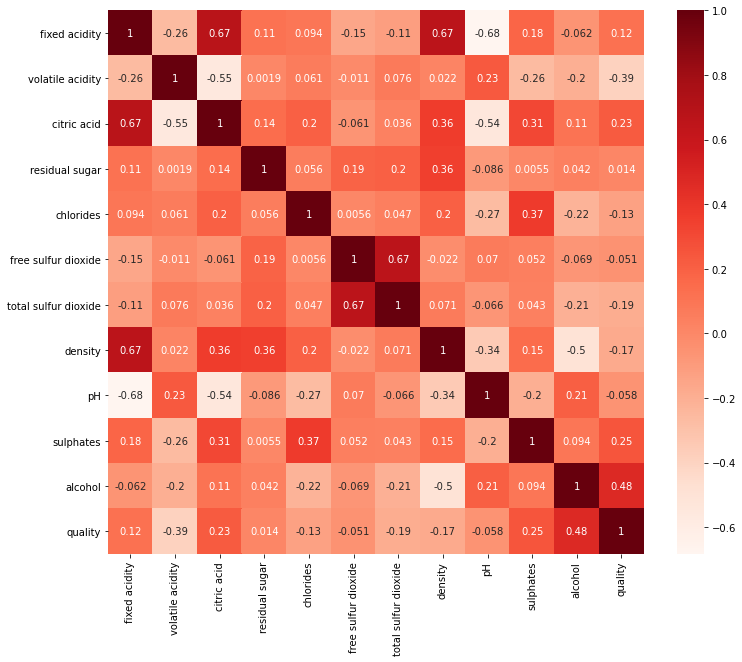

In [17]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show

In [18]:
#Datos de entrenamiento y de test
XEntreno, XTest, YEntreno, YTest = train_test_split(data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]], data.iloc[:,[11]], test_size=0.2)

In [19]:
#seleccionando variables que me pueden servir
cor_objetivo = abs(cor["quality"])

variables_relevantes = cor_objetivo[cor_objetivo>0.3]

print(variables_relevantes)

volatile acidity    0.390558
alcohol             0.476166
quality             1.000000
Name: quality, dtype: float64


In [20]:
#Para poder ver si estas dos variables se relacionan entre ellas utilizamos el siguiente código:
#Este nos permitirá decidir si utilizamos estas variables o no
#Si estan altamente correlacionadas no nos sirven.
print(data[["volatile acidity","alcohol"]].corr())


                  volatile acidity   alcohol
volatile acidity          1.000000 -0.202288
alcohol                  -0.202288  1.000000


In [21]:
#Aplicando tecnicas de Feature Engineering 

In [22]:
#Solo para validar como están  distribuidas estas dos variables a utilizar
data[["volatile acidity","alcohol"]].head()


,volatile acidity,alcohol
0,0.70,9.4
1,0.88,9.8
2,0.76,9.8
3,0.28,9.8
4,0.70,9.4


In [23]:
#Solo para validar como se distribuyen estadisticamente las 2 variables a utilizar.
data[["volatile acidity","alcohol"]].describe()

,volatile acidity,alcohol
count,1599.000000,1599.000000
mean,0.527821,10.422983
std,0.179060,1.065668
min,0.120000,8.400000
25%,0.390000,9.500000
50%,0.520000,10.200000
75%,0.640000,11.100000
max,1.580000,14.900000


Text(0, 0.5, 'Frequency')

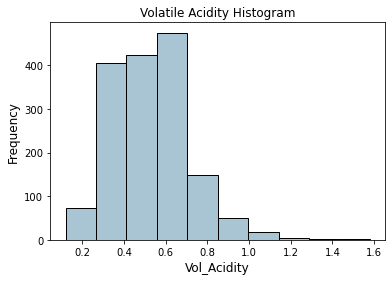

In [24]:
#Frecuencia de variable Volatile_Acidity
fig, ax = plt.subplots()
data["volatile acidity"].hist(color='#A9C5D3', edgecolor='black',  grid=False)
ax.set_title('Volatile Acidity Histogram', fontsize=12)
ax.set_xlabel('Vol_Acidity', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

Text(0, 0.5, 'Frequency')

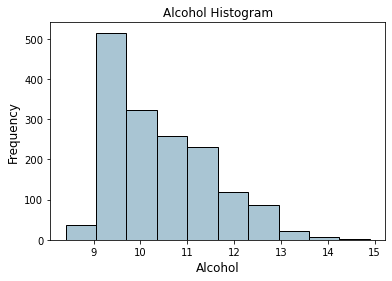

In [25]:
#Frecuencia de variable Alcohol
fig, ax = plt.subplots()
data["alcohol"].hist(color='#A9C5D3', edgecolor='black',  grid=False)
ax.set_title('Alcohol Histogram', fontsize=12)
ax.set_xlabel('Alcohol', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

### Probando transformar ambas variables con Log transformation

In [26]:
data['volatile acidity_log'] = np.log((1+data['volatile acidity']))

Text(0, 0.5, 'Frequency')

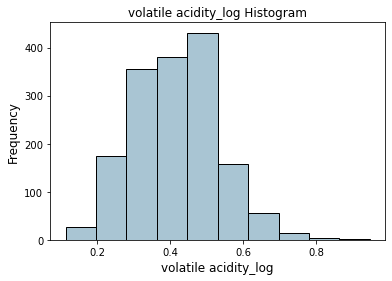

In [27]:
#Frecuencia de variable volatile acidity
fig, ax = plt.subplots()
data["volatile acidity_log"].hist(color='#A9C5D3', edgecolor='black',  grid=False)
ax.set_title('volatile acidity_log Histogram', fontsize=12)
ax.set_xlabel('volatile acidity_log', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [28]:
data['alcohol_log'] = np.log((1+data['alcohol']))

Text(0, 0.5, 'Frequency')

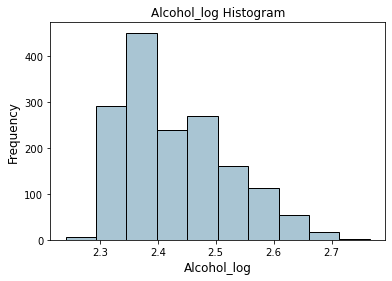

In [29]:
#Frecuencia de variable Alcohol
fig, ax = plt.subplots()
data["alcohol_log"].hist(color='#A9C5D3', edgecolor='black',  grid=False)
ax.set_title('Alcohol_log Histogram', fontsize=12)
ax.set_xlabel('Alcohol_log', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

<AxesSubplot:ylabel='Density'>

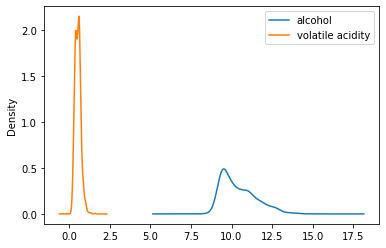

In [30]:
#Densidad antes de transformacion
data[["alcohol", "volatile acidity"]].plot.kde()

<AxesSubplot:ylabel='Density'>

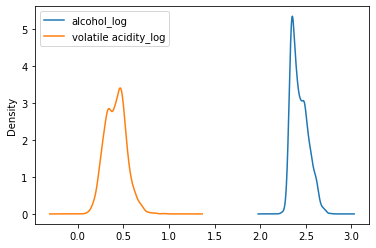

In [31]:
#Densidad despues de transformacion:
data[["alcohol_log", "volatile acidity_log"]].plot.kde()

Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$

In [32]:
#data[["alcohol", "volatile acidity"]]
df_modelo = []
#Variables que agregaremos al dataset:

cuadrado_a = pow(data[["alcohol"]],2)
cuadrado_b = pow(data[["volatile acidity"]],2) 
multiplicador = data[["volatile acidity"]] * data[["alcohol"]]

numero_1 = []
for col in range(len(data)):
    numero_1.append(1)

df_modelo = pd.DataFrame(numero_1)
df_modelo["alcohol"]=data[["alcohol"]]
df_modelo["volatile acidity"] = data[["volatile acidity"]]
df_modelo["cuadrado a"] = cuadrado_a
df_modelo["cuadrado b"] = cuadrado_b
df_modelo["multip"] = data["volatile acidity"] * data["alcohol"]




In [33]:
#print(data[["volatile acidity"]] * data[["alcohol"]])
df_modelo.head()

,0,alcohol,volatile acidity,cuadrado a,cuadrado b,multip
0,1,9.4,0.70,88.36,0.4900,6.580
1,1,9.8,0.88,96.04,0.7744,8.624
2,1,9.8,0.76,96.04,0.5776,7.448
3,1,9.8,0.28,96.04,0.0784,2.744
4,1,9.4,0.70,88.36,0.4900,6.580


In [34]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [35]:

%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)


lr = 0.0001
bs = 500
ep = 500



In [3]:
class ModeloLinealMul:
  def __init__(self,n):
    tf.reset_default_graph()
    self.parametros = tf.get_variable("Parametros",dtype=tf.float64,shape=[n,1],initializer=tf.zeros_initializer())
    self.error = tf.get_variable("Error",dtype=tf.float64,shape=[1],initializer=tf.zeros_initializer())
  def __call__(self,x): 
    return tf.linalg.matmul(x,self.parametros,name="Prediccion")
  def actualizar(self,x,y,learning_rate):
    prediccion = self(x)
    error = 1/2 * tf.math.reduce_mean(tf.math.square(y - prediccion,name="Error_Cuadrado"),axis=0,name="Error_Media") 
    gradiente = tf.gradients(error,self.parametros, name="Gradiente")  
    actualizacion_error = tf.assign(self.error, error)
    actualizacion_parametros = tf.assign(self.parametros,self.parametros - tf.multiply(gradiente,learning_rate)[0],name="Actualizacion_Parametros")
    return actualizacion_parametros,actualizacion_error

In [2]:
def ModeloRegresionLineal(X,Y,lr,batch,epochs):  
    m, n = X.shape  
    modelo = ModeloLinealMul(n)
    total_iter =  int(m/batch)
    tensor_x = tf.placeholder(tf.float64,[None,n],"tensor_x")
    tensor_y = tf.placeholder(tf.float64,[None,1],"tensor_y")
    prediccion = modelo(tensor_x)
    actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,lr)
    with tf.train.MonitoredSession() as session:
        tf.reset_default_graph()   
        log_dir = "logs/E_Multivariable/"+"BS-"+str(batch)+"_"+"LR-"+str(lr)+"_Polinomio-"+str(n-1)+"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        Grafo = tf.summary.FileWriter(log_dir, session.graph)
        for epoch in range(epochs):    
            for i in range(total_iter):          
                muestra_inicio = i*batch
                muestra_fin = muestra_inicio + batch
                x_parametros =  np.array(X[muestra_inicio:muestra_fin])
                y_parametros = np.array(Y[muestra_inicio:muestra_fin])
                feed_dict = {tensor_x:x_parametros, tensor_y:y_parametros}
                _,parametros,e = session.run([actualizacion_parametros,modelo.parametros,modelo.error],feed_dict=feed_dict)  
                summary = tf.Summary(value=[tf.Summary.Value(tag="Error", simple_value=e[0])])
                Grafo.add_summary(summary, epoch)
            feed_dict = {tensor_x:X, tensor_y:Y}
        PendienteInter_final = session.run([modelo.parametros],feed_dict=feed_dict)
        Grafo.close()
        print("Finalizad")

In [38]:
#Hiper parametros a utilizar
lr = 0.00001
bs = 350
ep = 350
df_modelo.head()

,0,alcohol,volatile acidity,cuadrado a,cuadrado b,multip
0,1,9.4,0.70,88.36,0.4900,6.580
1,1,9.8,0.88,96.04,0.7744,8.624
2,1,9.8,0.76,96.04,0.5776,7.448
3,1,9.8,0.28,96.04,0.0784,2.744
4,1,9.4,0.70,88.36,0.4900,6.580


In [52]:
X_enviar = df_modelo[["cuadrado a", "cuadrado b"]]
Y_enviar = data.to_numpy().reshape([-1,1])
lr = 0.0001
ep= 500
print(Y_enviar)

[[7.4       ]
 [0.7       ]
 [0.        ]
 ...
 [6.        ]
 [0.27002714]
 [2.48490665]]


In [53]:
ModeloRegresionLineal(X_enviar,Y_enviar,lr,500,ep)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Finalizad


In [54]:
%tensorboard --logdir logs/E_Multivariable --port 8889 

Reusing TensorBoard on port 8889 (pid 7468), started 0:08:21 ago. (Use '!kill 7468' to kill it.)

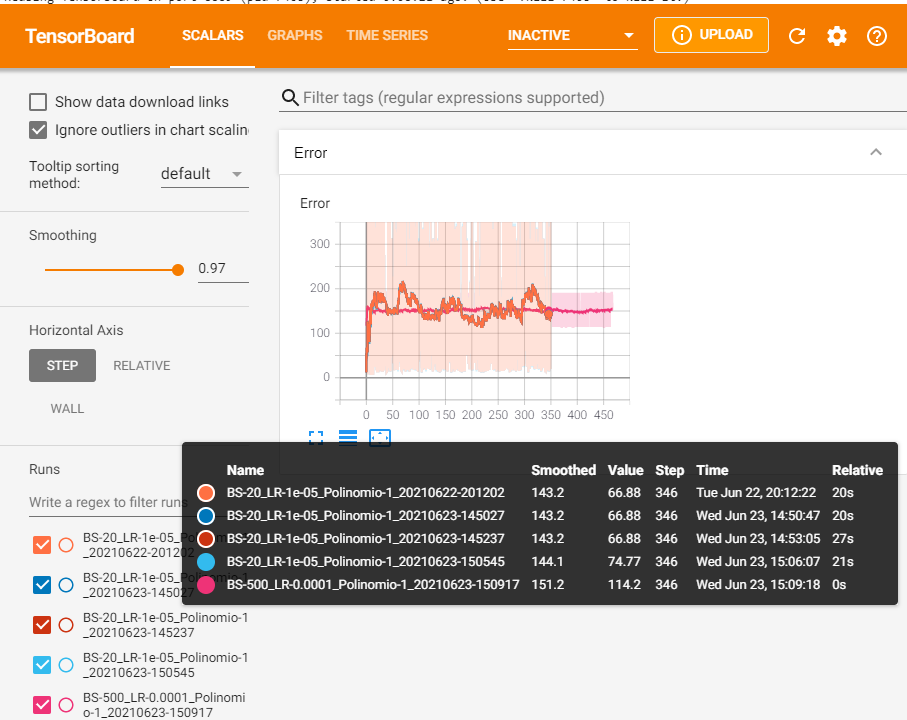